
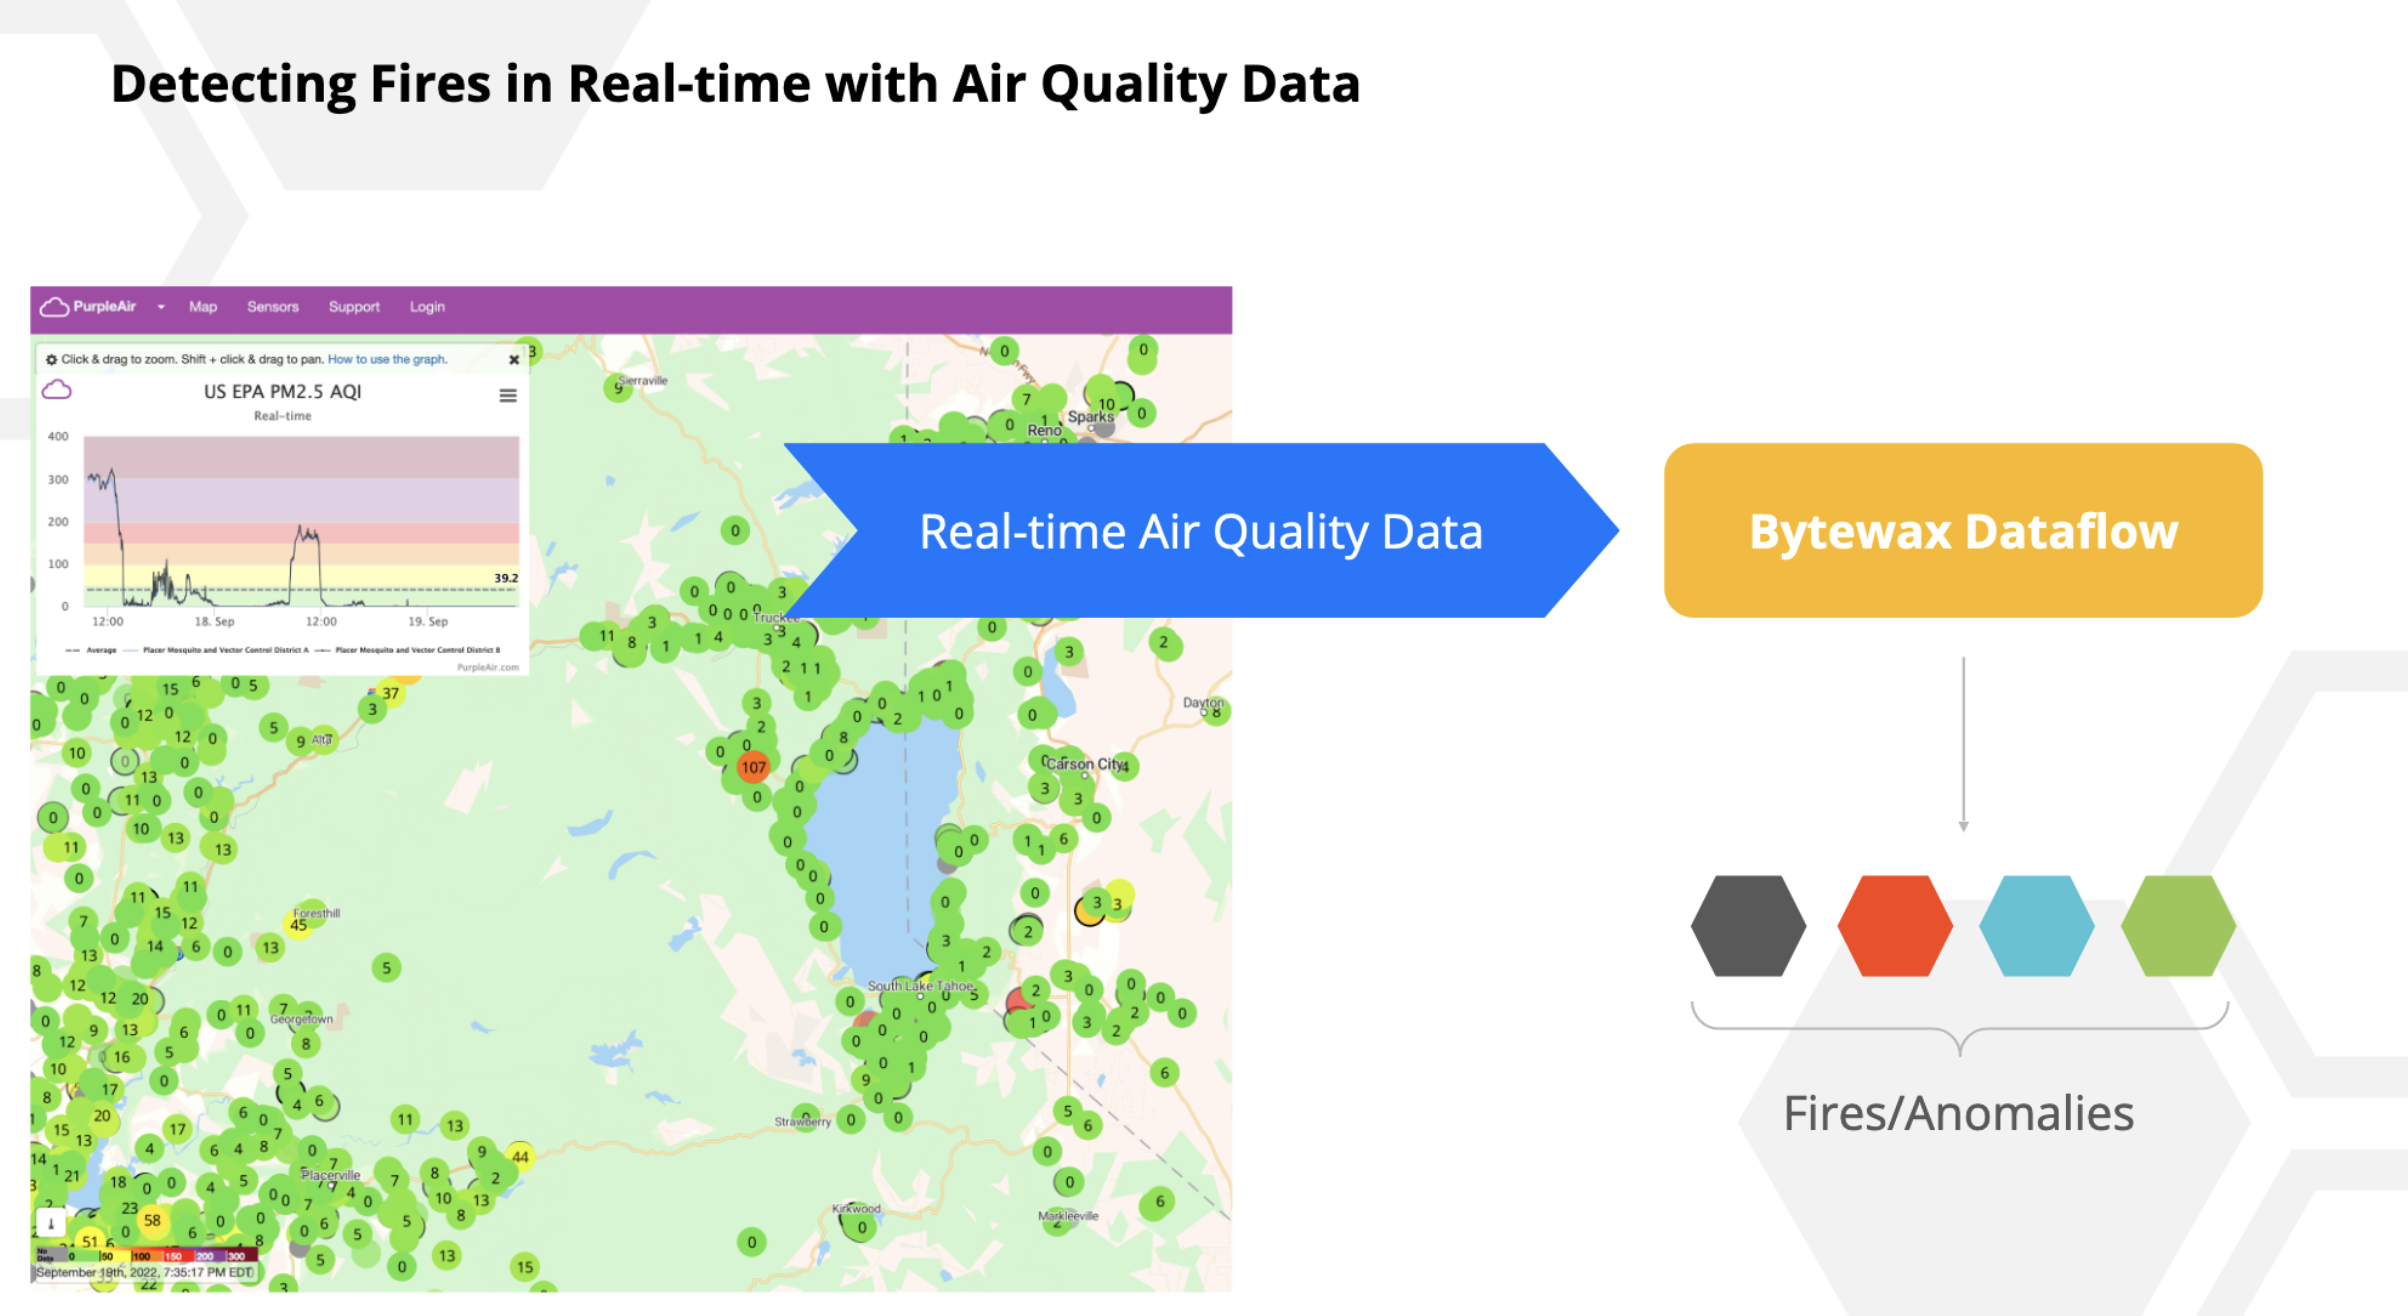


In [1]:
import json
from datetime import datetime, timedelta, timezone
import sys
import os
from collections import defaultdict

import requests

from geopy.geocoders import Nominatim
from bytewax.dataflow import Dataflow
from bytewax.inputs import KafkaInputConfig 
from bytewax.outputs import ManualOutputConfig, StdOutputConfig
from bytewax.window import TumblingWindowConfig, EventClockConfig
from bytewax.execution import run_main, spawn_cluster
from bytewax.recovery import KafkaRecoveryConfig

from scipy.stats import variation

from river import anomaly

import matplotlib.pyplot as plt

In [2]:
WEBHOOK_URL = os.getenv("WEBHOOK_URL")

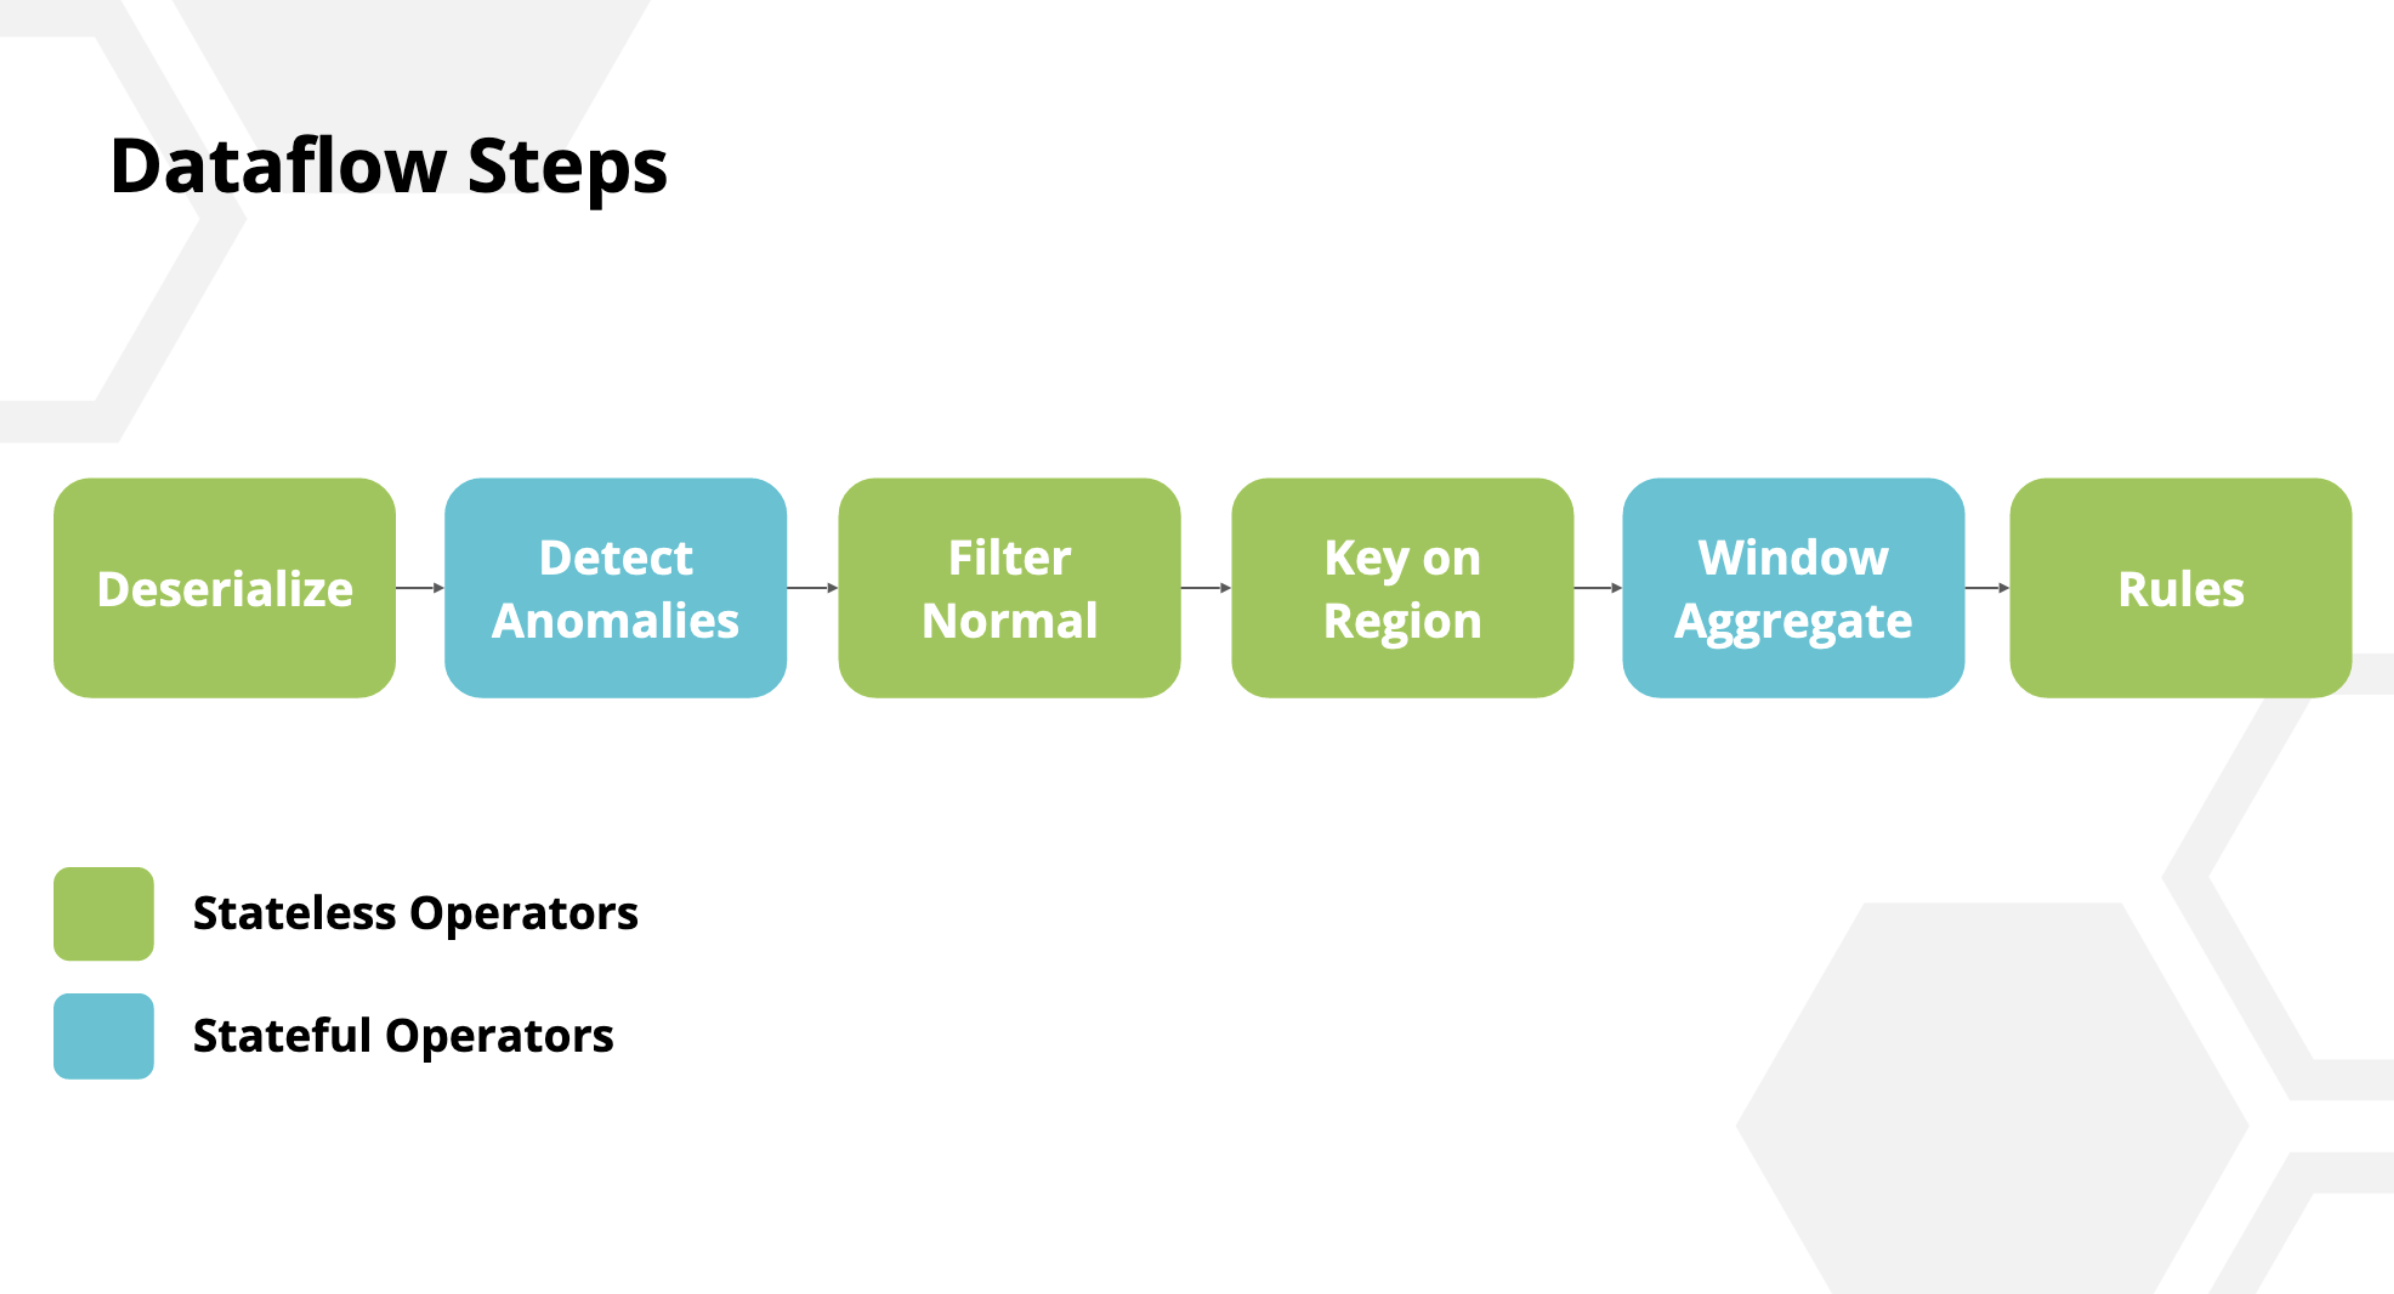


### Kafka Input

To start with, we are going to create our Dataflow object and then specify our input source. We are going to use data from Purple Air that has been loaded in to a kafka topic called `sensor_data`. The sensor location will be used as the key and the data as the payload.

For this example, since we are consuming a known, bounded stream of data, we will specify the starting offset as the beginning and the tail as false.

In [3]:
# Define Dataflow and input configuration
flow = Dataflow()
flow.input(
    "aqi_state", 
    KafkaInputConfig(
        brokers=["localhost:9092"], 
        topic="sensor_data",
        starting_offset = "beginning",
        tail = False
        )
    )

Next we will do some deserialization of the data in a `dataflow.map` operator.

In [4]:
# Deserialize input for processing
def deserialize(key_bytes__payload_bytes):
    key_bytes, payload_bytes = key_bytes__payload_bytes
    key = json.loads(key_bytes) if key_bytes else None
    sensor_data = json.loads(payload_bytes) if payload_bytes else None
    sensor_data['PM2.5_CF1_ug/m3'] = float(sensor_data['PM2.5_CF1_ug/m3'])
    sensor_data["created_at"] = datetime.strptime(sensor_data["created_at"], "%Y-%m-%d %H:%M:%S %Z").replace(tzinfo=timezone.utc)
    return key, sensor_data

flow.map(deserialize)

### Online ML for Anomaly Detection

With our data in the expected format, we are going to leverage the River library to detect anomalies on the PM2.5 ug/m3 data. This happens in a `dataflow.stateful_map` operator, which will create a new AnomalyDetector object for each key (sensor) and then for each additional datum we will score the new data and the update our model.

stateful objects use worker memory for state and then they persist the state to either Kafka or SQLite for recovery.

In [5]:
# anomaly detector Class for stateful map
class AnomalyDetector:

    def __init__(self, n_trees=10, height=8, window_size=72, seed=11):
        self.detector = anomaly.HalfSpaceTrees(
                                                n_trees=n_trees,
                                                height=height,
                                                window_size=window_size,
                                                # we are using 1200 as the max for this
                                                # dataset since we know in advanced it
                                                # is the highest
                                                limits={'x': (0.0, 1200)},
                                                seed=seed
                                                )
    
    def update(self, data):
        data['score'] = self.detector.score_one({'x': data['PM2.5_CF1_ug/m3']})
        self.detector.learn_one({'x': data['PM2.5_CF1_ug/m3']})
        return self, data

flow.stateful_map(
    step_id = "anomaly_detector",
    builder = lambda: AnomalyDetector(n_trees=4, height=3, window_size=50, seed=11),
    mapper = AnomalyDetector.update,
)

### Visualizing the data

Now that is done, we can take a look at our data by plotting it out in our notebook. This drastically slows down the dataflow because of the calls to plot at every new datum, so after running it, you should interrupt the kernel and then comment the operator out.

In [6]:
%matplotlib notebook
plt.ion()

In [7]:
class DrawPlot():
    def __init__(self):
        # define plot
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.xs = defaultdict(list)
        self.ys = defaultdict(list)

        # Format plot
        self.ax.tick_params(labelrotation=45)
        self.fig.subplots_adjust(bottom=0.30)
        self.ax.set_title('PM2.5 over Time')
        self.ax.set_ylabel('CF1_ug/m3')

    def plot(self, key__data):
        key, sensor_data = key__data

        # Add x and y to lists
        self.xs[key].append(sensor_data['created_at'])
        self.ys[key].append(sensor_data['PM2.5_CF1_ug/m3'])

        # Limit x and y lists to 20 items
        self.xs[key] = self.xs[key][-20:]
        self.ys[key] = self.ys[key][-20:]

        # Draw x and y lists
        self.ax.clear()
        for key in self.xs.keys():
            self.ax.plot(self.xs[key], self.ys[key])

        self.fig.canvas.draw()

# dp = DrawPlot()
# flow.inspect(dp.plot)

In [8]:
# run_main(flow)

### Filtering Anomalies

We have visually inspected our data and now it we want to remove the normal data to see just the data that has a score of greater than 0.7 and a PM2.5 greater than 50 since we won't care about anomalies going in the other direction from high to low.

In [9]:
# threshold filtering
flow.filter(lambda x: x[1]['score']>0.7)
flow.filter(lambda x: float(x[1]['PM2.5_CF1_ug/m3'])>50)

In [10]:
# flow.inspect(print)

In [11]:
# run_main(flow)

### Differentiating Between Smoke and Malfunction

At this point we can see we have a number of anomalous events, but we can't easily determine if they are anomalous because they are a malfunctioning sensor or if they are truly the sign of a smoke event due to nearby fire.

To determine if it is a malfunction or a smoke event, we can do some aggregation by region over time to see if the high PM2.5 persists across the region and over time. To do this, we can first convert the sensor key, which is "lat, long" to a region.

In [12]:
# reformat to group by region instead of by individual sensor
def groupby_region(loc__data):
    coordinates, data = loc__data
    # add the sensor location to the data payload
    data["coordinates"] = coordinates

    # Uncomment this code if you want to convert the lat, long to county automatically
    # locator = Nominatim(user_agent="myGeocoder")
    # location = locator.reverse(coordinates)
    # key = location.raw['address']['county']

    # since we know the location of these we will mark the key manually
    # as the generalized area we are interested in 
    key = "Lake Tahoe"
    return key, data

flow.map(groupby_region)

Now we can use another stateful operator `fold_window` to group the sensor data together over time. The windowing operators in bytewax can work on either system time or event time and they can handle late arriving data depending on what we specify. Similar to the `stateful_map` used earlier in the dataflow, for each new key, we will create and object and then for each new datum we will update the object.

In [13]:
# setup an event-time based window to be used with `created_at` field
def get_event_time(event):
    return event["created_at"]

# We need to specify a wait time that is as long as the difference between
# the oldest (2022-07-01) and the newest (2022-09-18) to ensure out of order
# events are handled correctly
cc = EventClockConfig(get_event_time, wait_for_system_duration=timedelta(hours=12))

# Manually set the start time for this dataflow, this is known for this dataset 
start_at = datetime.strptime("2022-07-18 00:00:00 UTC", "%Y-%m-%d %H:%M:%S %Z").replace(tzinfo=timezone.utc)
wc = TumblingWindowConfig(start_at=start_at, length=timedelta(hours=12))

# Anomalies class to be used in the event-time window
class Anomalies:

    def __init__(self):
        self.sensors = []
        self.times = []
        self.values = []

    def update(self, event):
        self.sensors.append(event["coordinates"])
        self.times.append(event["created_at"])
        self.values.append(float(event["PM2.5_CF1_ug/m3"]))

        return self

flow.fold_window("count_sensors", cc, wc, Anomalies, Anomalies.update)

Here we use some statistics and heuristics on the accumulated window of data to infer whether the data was a malfunctioning sensor or a smoke event.

In [14]:
# Calculate some statistics and use rules to separate smoke events from malfunctions
def convert(key__anomalies):
    key, anomalies = key__anomalies
    
    # check is more than one sensor anomalous
    count_sensors = len(set(anomalies.sensors))
    count_anomalies = len(anomalies.values)
    min_event = min(anomalies.times)
    max_pm25 = max(anomalies.values)
    sensors = set(anomalies.sensors)
    malfunction = False
    anom_variance = None

    if count_sensors < 2:
        if count_anomalies < 10:
            malfunction = True
        else:
            # simplification, if there is wild variance in the data it is 
            # possibly a false positive
            anom_variance = variation(anomalies.values)
            if anom_variance > 0.3:
                malfunction = True

    return (key, {
            "sensors": sensors,
            "count_sensors": count_sensors,
            "count_anomalies": count_anomalies,
            "anomalies": anomalies.values,
            "min_event": min_event,
            "max_pm25": max_pm25,
            "variance": anom_variance,
            "malfunction": malfunction
            })

flow.map(convert)

### Data Output

Bytewax has some native connectors that we have developed in house, but it is also possible to leverage Python client libraries in an output builder. To write data from the dataflow to different downstream systems. In this dataflow, we are writing to slack with the information about the malfunctioning sensors and potential fires.

In this example, we are running a single thread, single process dataflow since we are doing some investigation and iterating on the example, but in production I could then scale up this data flow to multiple workers to match the parallelization of the kafka stream.

In [15]:
# output smoke event data to slack channel
def output_builder(worker_index, worker_count):
    
    def send_to_slack(key__sensor_data):
        location, sensor_data = key__sensor_data
        if sensor_data['malfunction']:
            message = f'''In {location} was a malfunctioning sensor at location
                            {sensor_data['sensors']} at {sensor_data['min_event']}'''
            title = (f"Malfunctioning Sensor")
        else:
            message = f'''In {location} there is a suspected smoke event from a fire reported 
                        by sensors at {sensor_data['sensors']} at {sensor_data['min_event']}'''
            title = (f"Suspected Smoke Event")
        slack_data = {
            "username": "Air Quality Bot",
            "icon_emoji": ":satellite:",
            "channel" : "#hacking-on-bytewax",
            "attachments": [
                {
                    "color": "#9733EE",
                    "fields": [
                        {
                            "title": title,
                            "value": message,
                            "short": "false",
                        }
                    ]
                }
            ]
        }
        byte_length = str(sys.getsizeof(slack_data))
        headers = {'Content-Type': "application/json", 'Content-Length': byte_length}
        response = requests.post(WEBHOOK_URL, data=json.dumps(slack_data), headers=headers)
        if response.status_code != 200:
            raise Exception(response.status_code, response.text)

    return send_to_slack

flow.capture(
    # StdOutputConfig()
    ManualOutputConfig(output_builder)
    )

In [16]:
run_main(flow)

thread '<unnamed>' panicked at 'Box<dyn Any>', src/operators/mod.rs:26:27
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


KeyboardInterrupt: 

### Scaling and Recovery

Bytewax dataflows are data parallel, so they scale across IO as demonstrated in the image below.

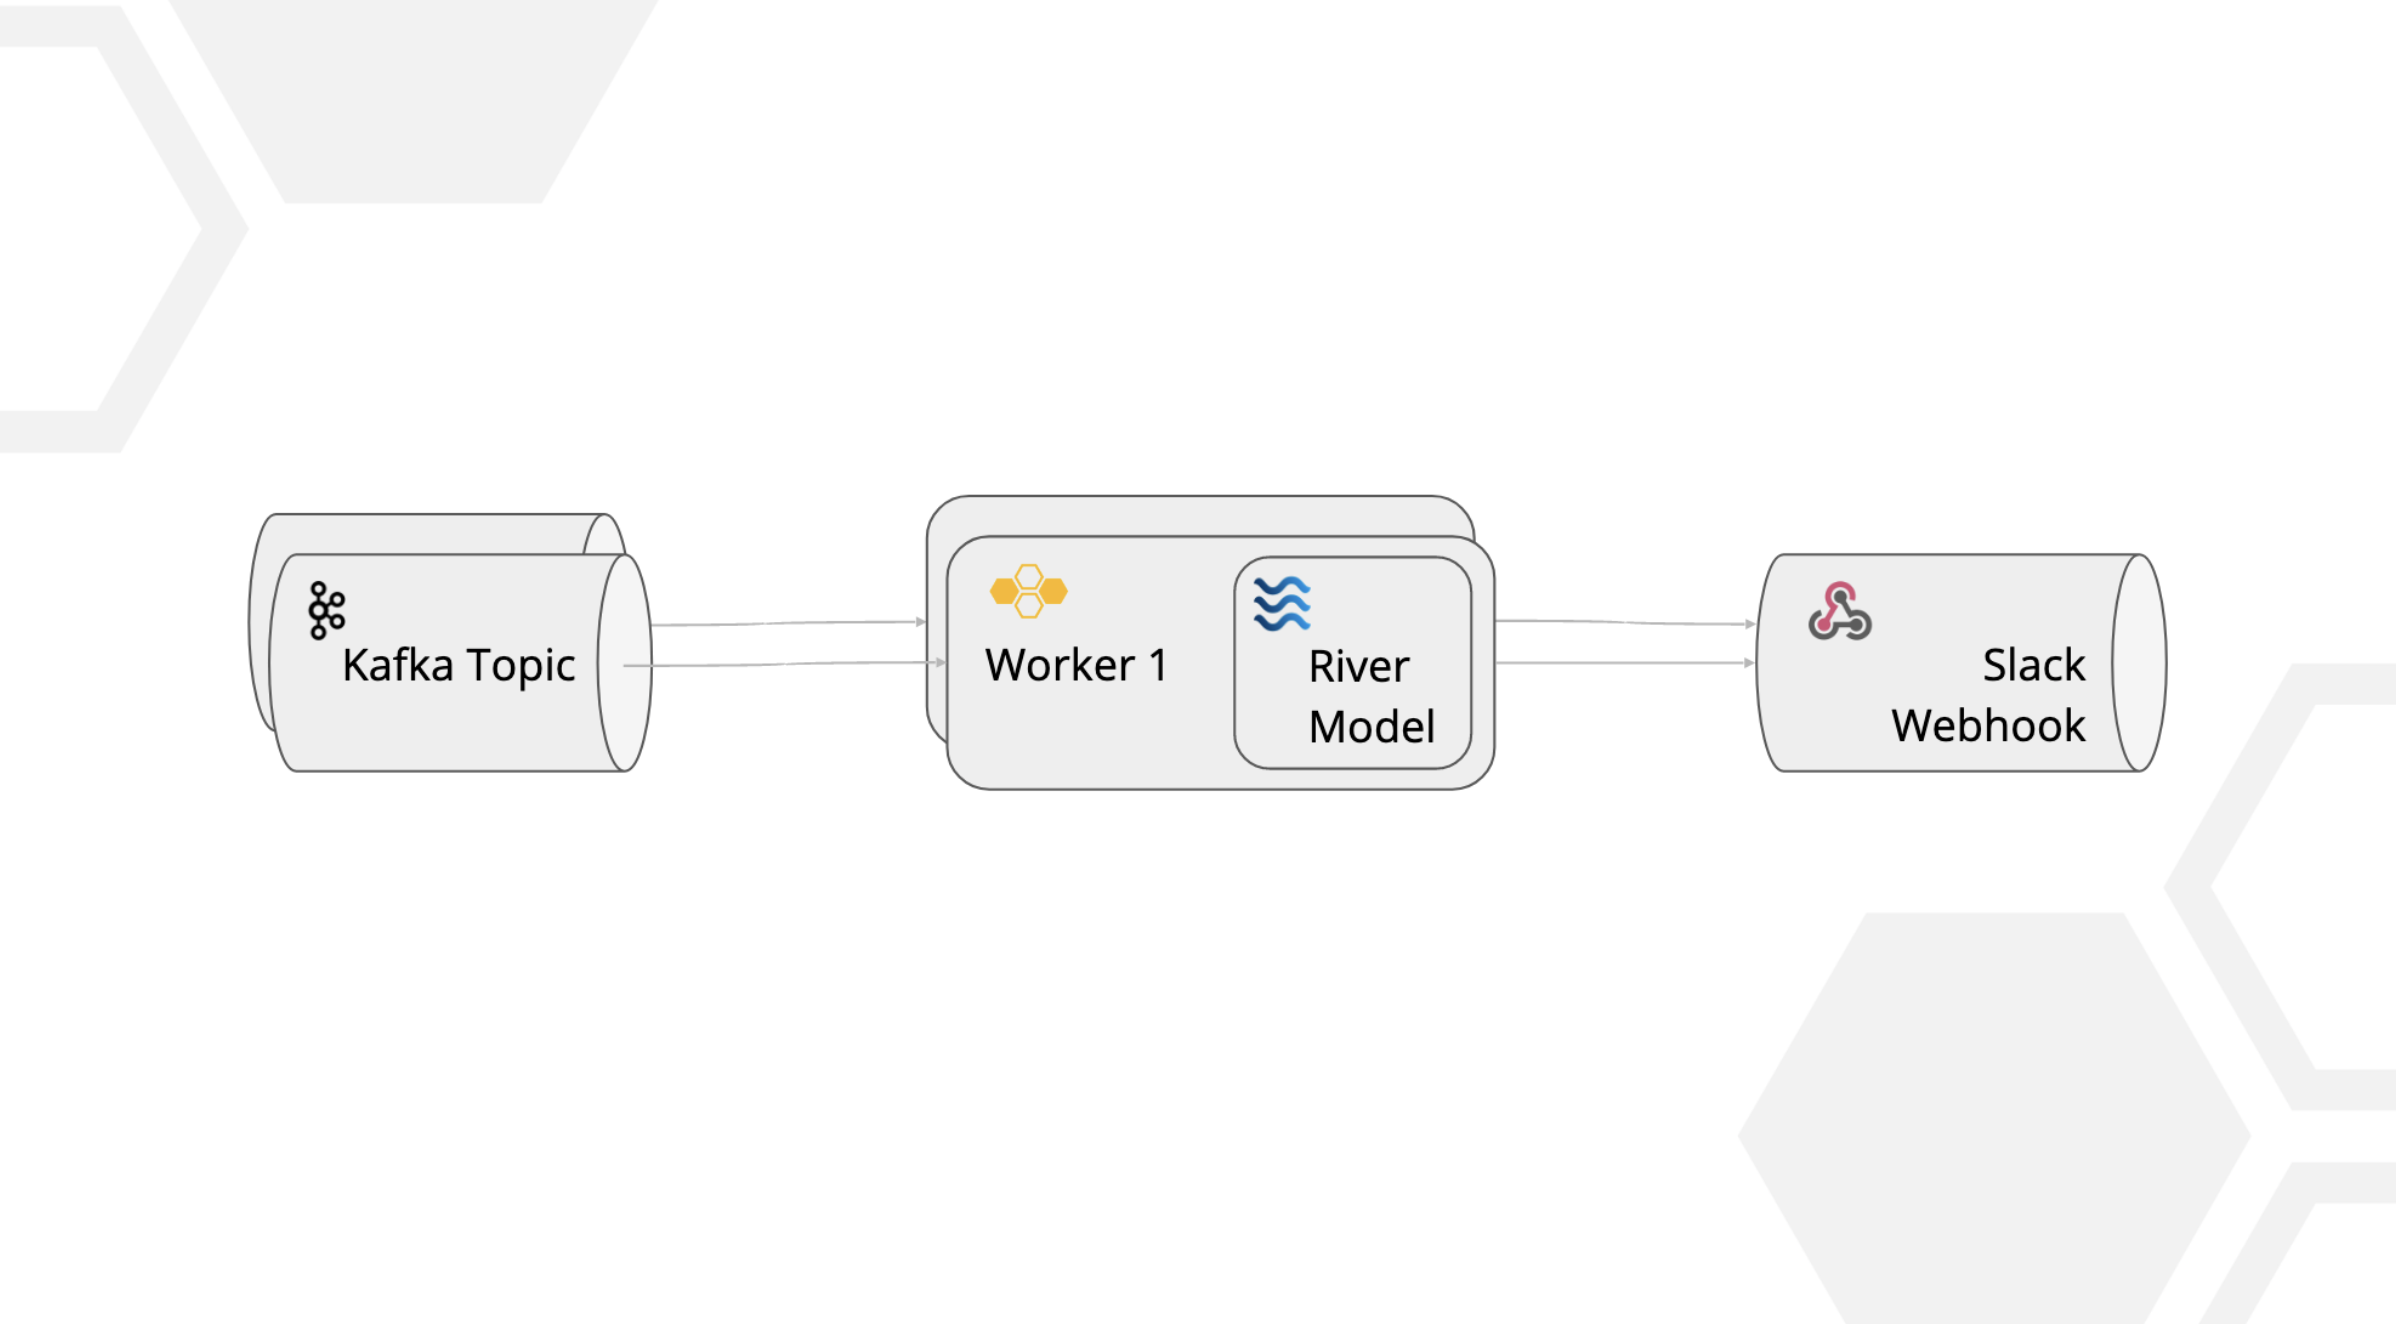

We have now run our dataflow on a single worker in a single process and although we are happy with the results, it is quite CPU intensive, so let's see if we can speed it up by increasing the number of processes. Let's look at how we can scale it up and add recovery. 

**This shouldn't be run in a Jupyter notebook context.**

In [18]:
# recovery_config = KafkaRecoveryConfig(
#     ["localhost:9092"],
#     "sensor_data_recovery",
#     )
# spawn_cluster(
#         flow,
#         recovery_config=recovery_config,
#         proc_count=3,
#     )